In [1]:
import pandas as pd

%load_ext autoreload
%autoreload 2

In [9]:
import numpy as np

from counterfactuals.datasets import CreditDefaultDataset
from counterfactuals.discriminative_models import MultilayerPerceptron

In [5]:
# dataset = HelocDataset("../data/heloc.csv", shuffle=False)
dataset = CreditDefaultDataset("../data/credit_default.csv", shuffle=False)

In [6]:
disc_model = MultilayerPerceptron(dataset.X_test.shape[1], [128, 128], 2, dropout=0.2)
# disc_model.fit(
#     dataset.train_dataloader(batch_size=128, shuffle=True),
#     dataset.test_dataloader(batch_size=128, shuffle=False),
#     epochs=500,
#     patience=100,
#     lr=1e-3,
#     checkpoint_path="disc_model.pt",
# )
# # disc_model.load("heloc_disc_model.pt")
disc_model.load("credit_default_disc_model.pt")
disc_model.eval()

/Users/oleksiifurman/Developer/counterfactuals/counterfactuals/discriminative_models/multilayer_perceptron.py:117: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_st

MultilayerPerceptron(
  (layers): ModuleList(
    (0): Linear(in_features=23, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (final_activation): Softmax(dim=1)
  (criterion): CrossEntropyLoss()
)

In [10]:
disc_model.eval()
y_pred = disc_model.predict(dataset.X_test).detach().numpy().flatten()
print("Test accuracy:", (y_pred == np.argmax(dataset.y_test, axis=1)).mean())

Test accuracy: 0.8299331390365163


In [11]:
from counterfactuals.cf_methods.ares import AReS

/Users/oleksiifurman/Developer/counterfactuals/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
from sklearn.preprocessing import LabelEncoder


def one_hot(dataset, data):
    """
    Improvised method for one-hot encoding the data

    Input: data (whole dataset)
    Outputs: data_oh (one-hot encoded data)
             features (list of feature values after one-hot encoding)
    """
    label_encoder = LabelEncoder()
    data_encode = data.copy()
    dataset.bins = {}
    dataset.bins_tree = {}
    dataset.features_tree = {}
    dataset.n_bins = None

    # Assign encoded features to one hot columns
    data_oh, features = [], []
    for x in data.columns:
        dataset.features_tree[x] = []
        categorical = x in dataset.categorical_features
        if categorical:
            data_encode[x] = label_encoder.fit_transform(data_encode[x])
            cols = label_encoder.classes_
        elif dataset.n_bins is not None:
            data_encode[x] = pd.cut(
                data_encode[x].apply(lambda x: float(x)), bins=dataset.n_bins
            )
            cols = data_encode[x].cat.categories
            dataset.bins_tree[x] = {}
        else:
            data_oh.append(data[x])
            features.append(x)
            continue

        one_hot = pd.get_dummies(data_encode[x])
        data_oh.append(one_hot)
        for col in cols:
            feature_value = x + " = " + str(col)
            features.append(feature_value)
            dataset.features_tree[x].append(feature_value)
            if not categorical:
                dataset.bins[feature_value] = col.mid
                dataset.bins_tree[x][feature_value] = col.mid

    data_oh = pd.concat(data_oh, axis=1, ignore_index=True)
    data_oh.columns = features
    return data_oh, features

In [14]:
dataset_for_ares = CreditDefaultDataset(
    "../data/credit_default.csv", transform=False, shuffle=False
)
data_oh, features = one_hot(
    dataset_for_ares,
    pd.DataFrame(dataset_for_ares.X_train, columns=dataset_for_ares.features[:-1]),
)

In [15]:
def predict_fn(x):
    x_scaled = dataset.feature_transformer.transform(x)
    return disc_model.predict(x_scaled).detach().numpy().flatten()

In [16]:
dataset_for_ares.X_test.shape

(5833, 23)

In [17]:
ares = AReS(
    predict_fn=predict_fn,
    dataset=dataset_for_ares,
    X=pd.DataFrame(dataset_for_ares.X_test, columns=dataset_for_ares.features[:-1]),
    dropped_features=[],
    n_bins=10,
    ordinal_features=[],
    normalise=False,
    constraints=[20, 7, 10],
)

/Users/oleksiifurman/Developer/counterfactuals/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


InvalidIndexError: (slice(None, None, None), 0)

In [83]:
ares.generate_itemsets(
    apriori_threshold=0.2,
    max_width=None,  # defaults to e2-1
    affected_subgroup=None,
    save_copy=False,
)
# Note: progress bar initial time estimate about 10 times too large
ares.generate_groundset(
    max_width=None, RL_reduction=True, then_generation=None, save_copy=False
)
lams = [1, 0]  # can play around with these lambda values
ares.evaluate_groundset(
    lams=lams, r=5000, save_mode=1, disable_tqdm=False, plot_accuracy=False
)
ares.select_groundset(s=5000)
ares.optimise_groundset(
    lams=lams, factor=1, print_updates=False, print_terms=False, plot_accuracy=False
)

Computing Candidate Sets of Conjunctions of Predicates SD and RL
Processing 21744 combinations | Sampling itemset size 6
SD and RL Computed with Lengths 4423 and 4423
Computing Ground Set of Triples V
Reducing RL
RL Reduced from Size 4423 to 533


100%|██████████| 4423/4423 [00:17<00:00, 252.76it/s] 


Ground Set Computed with Length 608208


4999it [00:05, 971.18it/s] 


Candidate Set Filtered with Length: 5000
Initialising Copy of Ground Set
While there exists a delete/update operation, loop:
Checking Delete
Checking Add


100%|██████████| 4999/4999 [00:00<00:00, 296169.58it/s]


Checking Exchange


100%|██████████| 4988/4988 [00:02<00:00, 1895.21it/s]


Checking Delete
Checking Add


100%|██████████| 4988/4988 [00:00<00:00, 343601.18it/s]


Checking Exchange


100%|██████████| 4988/4988 [00:02<00:00, 1931.41it/s]
11it [00:00, 828.18it/s]


In [96]:
ares.V.accuracy

10.767790262172285

In [13]:
# use higher apriori threshold than usual
ares.generate_itemsets(
    apriori_threshold=0.6,
    max_width=None,  # defaults to e2-1
    affected_subgroup=None,
    save_copy=False,
)

Computing Candidate Sets of Conjunctions of Predicates SD and RL
Processing 300 combinations | Sampling itemset size 6
SD and RL Computed with Lengths 199 and 199


In [14]:
q = 1 / dataset.X_train.shape[0]  # threshold for apriori during Then Generation

In [15]:
# generates a smaller groundset for a given time, though normally with better rules
ares.generate_groundset(
    max_width=None, RL_reduction=False, then_generation=q, save_copy=False
)

Computing Ground Set of Triples V


100%|██████████| 199/199 [00:55<00:00,  3.60it/s]

Ground Set Computed with Length 398452


0it [00:00, ?it/s]/Users/oleksiifurman/Developer/counterfactuals/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/oleksiifurman/Developer/counterfactuals/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/oleksiifurman/Developer/counterfactuals/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/oleksiifurman/Developer/counterfactuals/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/oleksiifurman/Developer/counterfactuals/venv/lib/python3.11

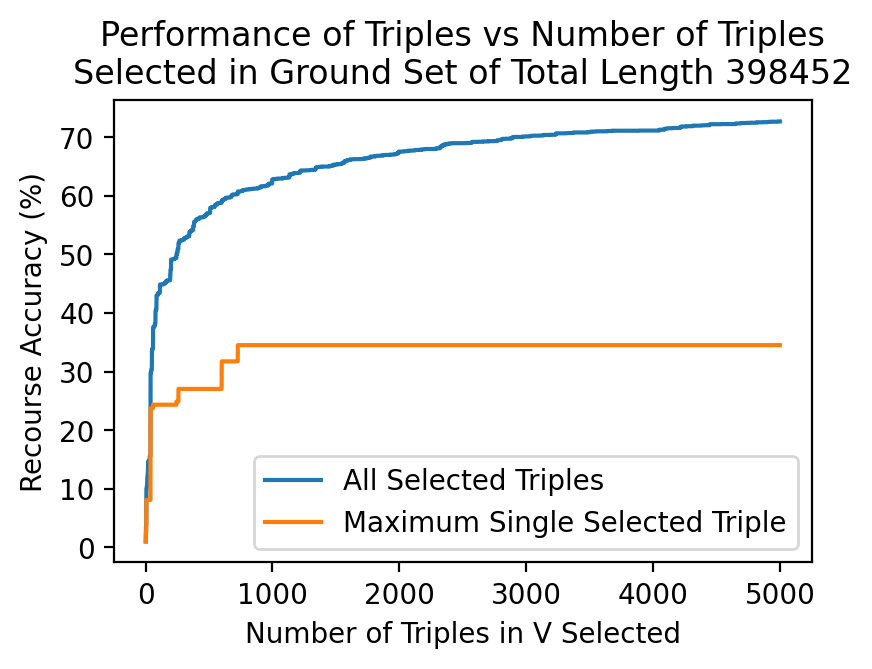

In [16]:
lams = [1, 10]  # can play around with these lambda values
ares.evaluate_groundset(
    lams=lams, r=5000, save_mode=1, disable_tqdm=False, plot_accuracy=True
)

In [17]:
ares.select_groundset(s=5000)

Candidate Set Filtered with Length: 5000


Initialising Copy of Ground Set
While there exists a delete/update operation, loop:
Checking Delete
Checking Add


100%|██████████| 4999/4999 [00:00<00:00, 474019.98it/s]


Checking Exchange


100%|██████████| 4980/4980 [00:03<00:00, 1279.25it/s]


Checking Delete
Checking Add
Checking Exchange


100%|██████████| 4980/4980 [00:03<00:00, 1568.17it/s]


Checking Delete
Checking Add
Checking Exchange


100%|██████████| 4980/4980 [00:03<00:00, 1245.71it/s]


Checking Delete
Checking Add
Checking Exchange


100%|██████████| 4980/4980 [00:03<00:00, 1395.58it/s]
0it [00:00, ?it/s]/Users/oleksiifurman/Developer/counterfactuals/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/oleksiifurman/Developer/counterfactuals/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/oleksiifurman/Developer/counterfactuals/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/oleksiifurman/Developer/counterfactuals/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/oleks

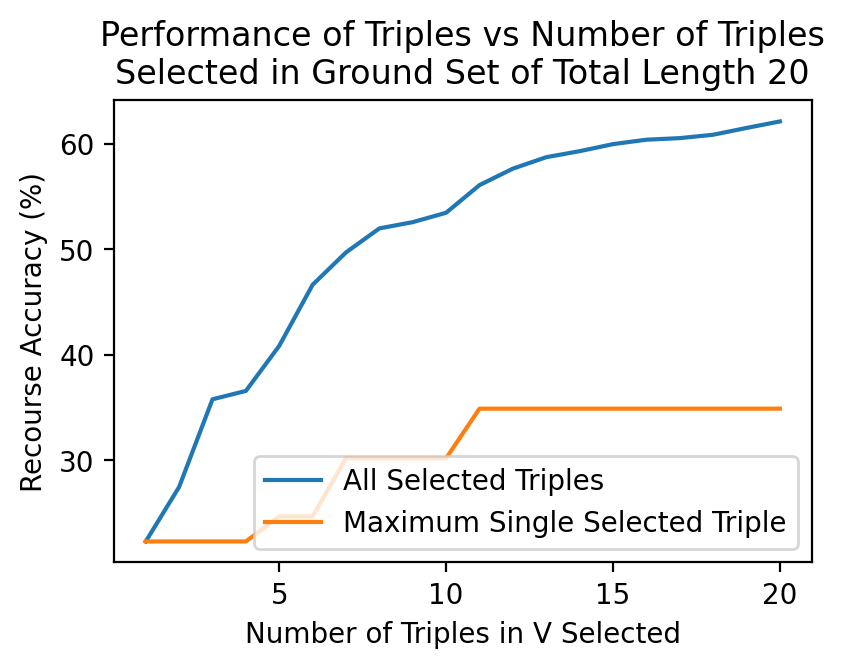

In [18]:
lams = [1, 10]  # can play around with these lambda values
ares.optimise_groundset(
    lams=lams, factor=1, print_updates=False, print_terms=False, save_copy=False
)

In [19]:
print("Accuracy:" + " {}%".format(round(ares.R.accuracy, 2)))
# only inputs with positive counterfactual predictions
print("Average Cost:" + " {}".format(round(ares.R.average_cost, 2)))

print(
    "\nAccuracy Upper Bound (Evaluated/Sorted Ground Set):"
    + " {}%".format(round(ares.V.accuracy, 2))
)

costs_ares, corrects_ares = ares.accuracy_cost_bounds(ares.R.cost_vector)

Accuracy: 62.12%
Average Cost: 3.79

Accuracy Upper Bound (Evaluated/Sorted Ground Set): 72.69%


In [20]:
ares.R.length

20

In [21]:
# clear the output to save space after running this cell
def bold(x: str) -> str:
    return "\033[1m" + x + "\033[0m"


print(bold("Final {} Triples Post-Optimisation\n".format(ares.R.length)))
for triple in ares.R.triples:
    outer_ifs, inner_ifs, thens = [sorted([j for j in triple[i]]) for i in range(3)]
    print(bold("If") + " {}:".format(", ".join(outer_ifs)))
    print(bold("\t  If") + " {}".format(", ".join(inner_ifs)))
    print(bold("\tThen") + " {}\n".format(", ".join(thens)))

Final 20 Triples Post-Optimisation

If PercentTradesNeverDelq = (90.0, 100.0]:
	  If MSinceMostRecentInqexcl7days = (-0.024, 2.4], NumInstallTradesWBalance = (0.978, 3.2]
	Then MSinceMostRecentInqexcl7days = (19.2, 21.6], NumInstallTradesWBalance = (5.4, 7.6]

If NumInqLast6M = (-0.066, 6.6], NumTrades60Ever2DerogPubRec = (-0.019, 1.9], NumTrades90Ever2DerogPubRec = (-0.019, 1.9]:
	  If NumInqLast6Mexcl7days = (-0.066, 6.6], NumInstallTradesWBalance = (0.978, 3.2]
	Then NumInqLast6Mexcl7days = (-0.066, 6.6], NumInstallTradesWBalance = (18.6, 20.8]

If MSinceMostRecentTradeOpen = (-0.227, 22.7], NumBank2NatlTradesWHighUtilization = (-0.018, 1.8]:
	  If MSinceMostRecentInqexcl7days = (-0.024, 2.4], NumInqLast6M = (-0.066, 6.6], NumInstallTradesWBalance = (0.978, 3.2]
	Then MSinceMostRecentInqexcl7days = (21.6, 24.0], NumInqLast6M = (-0.066, 6.6], NumInstallTradesWBalance = (3.2, 5.4]

If NetFractionInstallBurden = (47.1, 94.2], NumInqLast6M = (-0.066, 6.6]:
	  If MSinceMostRecentTradeOpe

In [67]:
ares.R.cfx_matrix.shape

(20, 4663, 23)